In [1]:
import os
import cv2
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(dataset_path):
    X, y = [], []
    label_map = {}
    label_idx = 0
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            if folder not in label_map:
                label_map[folder] = label_idx
                label_idx += 1
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (128, 128))  # Resize to fixed dimensions
                X.append(image.flatten())
                y.append(label_map[folder])
    return np.array(X), np.array(y)

In [3]:
def augment_data(X, y):
    X_aug = []
    y_aug = []
    
    datagen = ImageDataGenerator(
        # rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=(0.6, 1.4),
        channel_shift_range=0.1,
        fill_mode='nearest',
        featurewise_center=True,
        zca_whitening=True
    )

    X = X.reshape(-1, 128, 128, 1)
    
    for i in range(X.shape[0]):
        img = X[i].reshape((1, 128, 128, 1))
        for _ in range(10):  # Generate 10 augmented images per input
            aug_iter = datagen.flow(img, batch_size=1)
            aug_img = next(aug_iter)[0].astype('uint8')  # Correct usage of next()
            X_aug.append(aug_img.flatten())
            y_aug.append(y[i])

    return np.array(X_aug), np.array(y_aug)

In [4]:
# Load train, test, validation data
train_path = 'D:/organized_dataset/train'
test_path = 'D:/organized_dataset/test'
validation_path = 'D:/organized_dataset/val'

X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)
X_val, y_val = load_data(validation_path)

In [6]:
# Apply augmentation on training data
X_train_aug, y_train_aug = augment_data(X_train, y_train)

# Combine original and augmented data
X_train_combined = np.concatenate((X_train, X_train_aug), axis=0)
y_train_combined = np.concatenate((y_train, y_train_aug), axis=0)

In [7]:
lda = LDA(n_components=3)  # 3 components since we have 4 classes (n_classes - 1)
X_train_lda = lda.fit_transform(X_train_combined, y_train_combined)
X_test_lda = lda.transform(X_test)
X_val_lda = lda.transform(X_val)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Normalize the data before applying Ridge (L2 regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lda)
X_test_scaled = scaler.transform(X_test_lda)
X_val_scaled = scaler.transform(X_val_lda)

# Range of alpha values to test
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}

ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train_combined)

print("Best alpha:", grid_search.best_params_)

Best alpha: {'alpha': 0.01}


In [9]:
# Apply Ridge for L2 regularization
ridge = Ridge(alpha=0.01)  # Alpha controls the strength of the regularization
ridge.fit(X_train_scaled, y_train_combined)

# Ridge doesn't transform features but here it's used for feature scaling effects
X_train_ridge = X_train_scaled
X_test_ridge = X_test_scaled
X_val_ridge = X_val_scaled

In [10]:
from sklearn.model_selection import GridSearchCV

svm_clf = SVC()

param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)
grid_search.fit(X_train_ridge, y_train_combined)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 1}


In [11]:
svm_clf = SVC(kernel='linear', C=1)
svm_clf.fit(X_train_ridge, y_train_combined)

# Predictions
y_pred_train = svm_clf.predict(X_train_ridge)
y_pred_test = svm_clf.predict(X_test_ridge)
y_pred_val = svm_clf.predict(X_val_ridge)

In [12]:
# Print accuracy and classification report for the training set
print("Training Accuracy:", accuracy_score(y_train_combined, y_pred_train))
print("Classification Report (Training):\n", classification_report(y_train_combined, y_pred_train))

Training Accuracy: 0.9756393503826769
Classification Report (Training):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3355
           1       0.98      0.97      0.98      2211
           2       0.97      0.97      0.97      2739
           3       0.97      0.97      0.97      2409

    accuracy                           0.98     10714
   macro avg       0.98      0.98      0.98     10714
weighted avg       0.98      0.98      0.98     10714



In [13]:
# Print accuracy and classification report for the test set
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report (Test):\n", classification_report(y_test, y_pred_test))

Test Accuracy: 0.411214953271028
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.54      0.64      0.59        67
           1       0.27      0.36      0.31        44
           2       0.45      0.27      0.34        55
           3       0.33      0.29      0.31        48

    accuracy                           0.41       214
   macro avg       0.40      0.39      0.39       214
weighted avg       0.42      0.41      0.41       214



In [14]:
# Print accuracy and classification report for the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Classification Report (Validation):\n", classification_report(y_val, y_pred_val))

Validation Accuracy: 0.3588516746411483
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.49      0.48      0.48        65
           1       0.30      0.49      0.38        43
           2       0.31      0.15      0.20        53
           3       0.29      0.31      0.30        48

    accuracy                           0.36       209
   macro avg       0.35      0.36      0.34       209
weighted avg       0.36      0.36      0.35       209



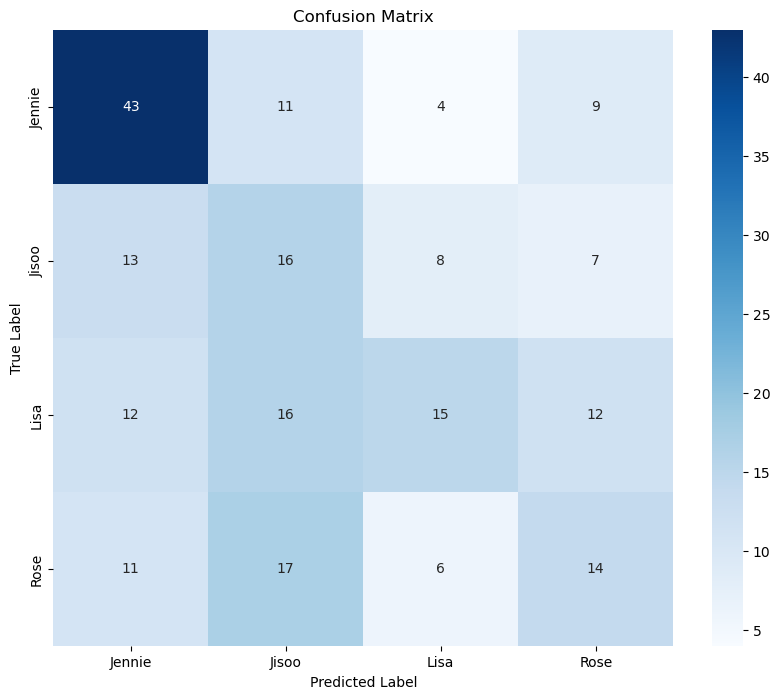

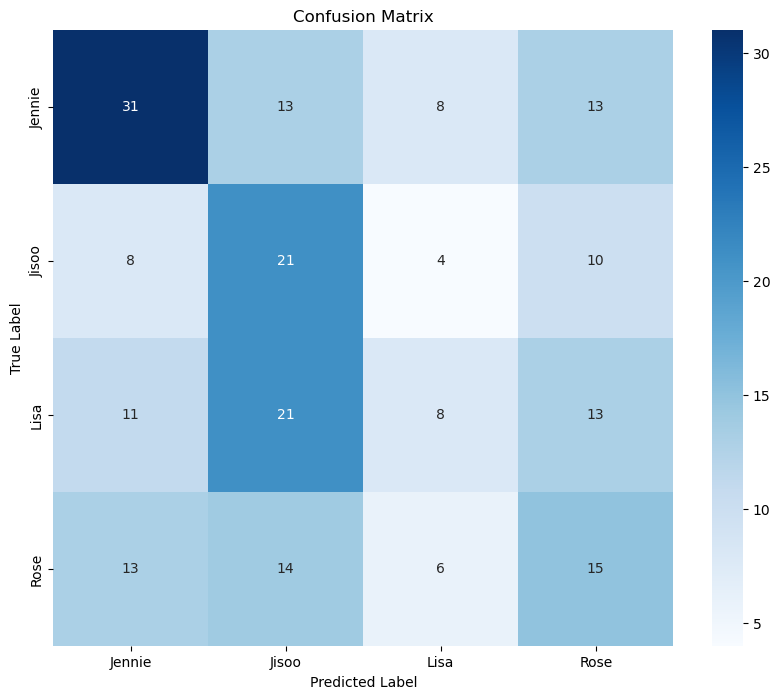

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

class_names = ['Jennie', 'Jisoo', 'Lisa', 'Rose']

# Plot confusion matrix for test set
plot_confusion_matrix(y_test, y_pred_test, class_names)

# Plot confusion matrix for validation set
plot_confusion_matrix(y_val, y_pred_val, class_names)

In [16]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(svm_clf, X_train_ridge, y_train_combined, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation scores: [0.97573495 0.98740084 0.97153523 0.9724685  0.96778711]
Mean CV score: 0.9750 (+/- 0.0134)


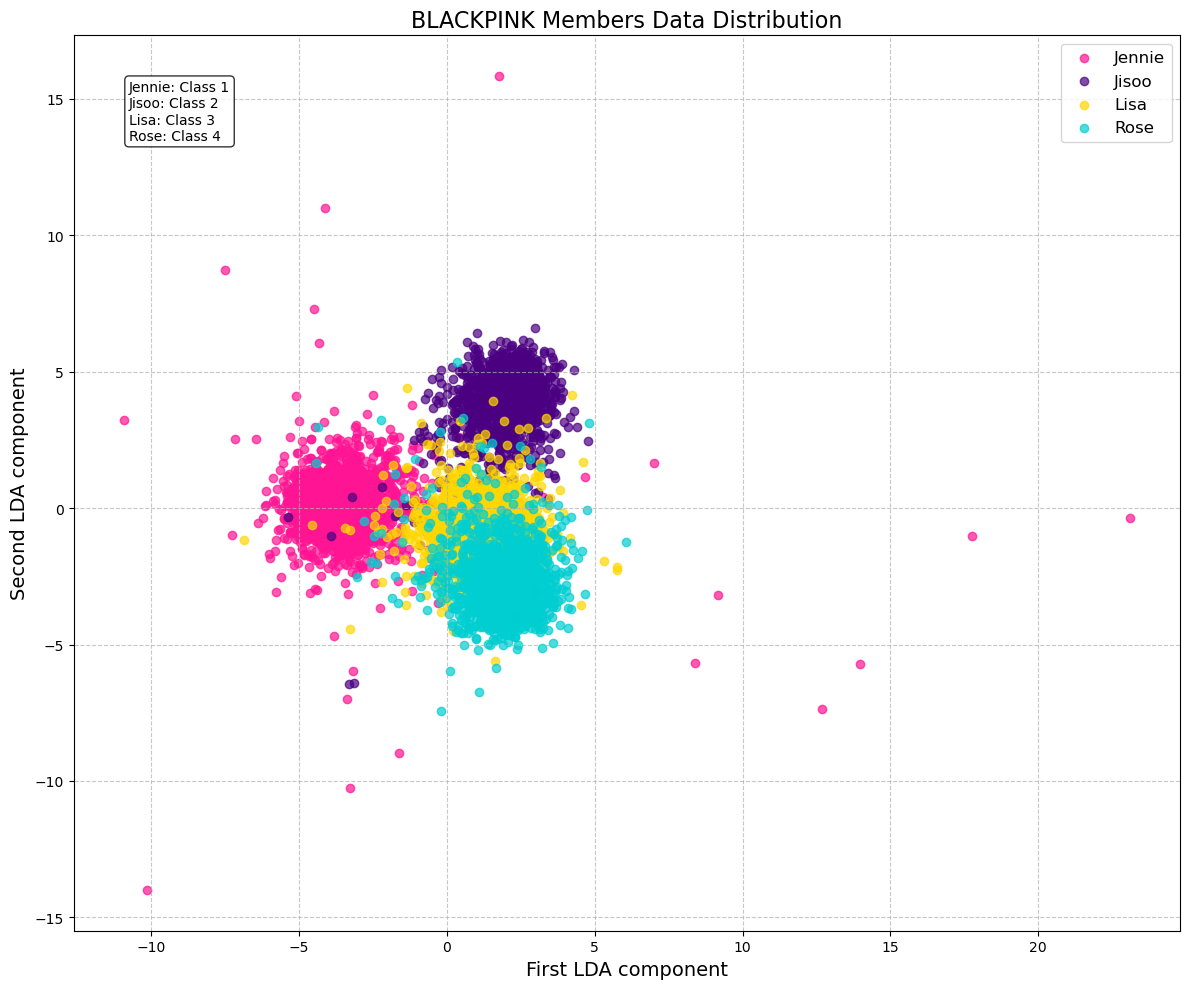

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data_distribution(X, y):
    plt.figure(figsize=(12, 10))
    
    # Define class names
    class_names = ['Jennie', 'Jisoo', 'Lisa', 'Rose']
    
    # Define colors for each class
    colors = ['#FF1493', '#4B0082', '#FFD700', '#00CED1']
    
    for i, class_name in enumerate(class_names):
        mask = y == i
        plt.scatter(X[mask, 0], X[mask, 1], 
                    label=class_name, 
                    color=colors[i], 
                    alpha=0.7)
    
    plt.legend(fontsize=12)
    plt.title('BLACKPINK Members Data Distribution', fontsize=16)
    plt.xlabel('First LDA component', fontsize=14)
    plt.ylabel('Second LDA component', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add a text box with class information
    info_text = '\n'.join([f"{name}: Class {i+1}" for i, name in enumerate(class_names)])
    plt.text(0.05, 0.95, info_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Plot data distribution
plot_data_distribution(X_train_lda[:, :2], y_train_combined)

Predicted probabilities:
Jennie: 1.83%
Jisoo: 3.15%
Lisa: 0.48%
Rose: 94.54%


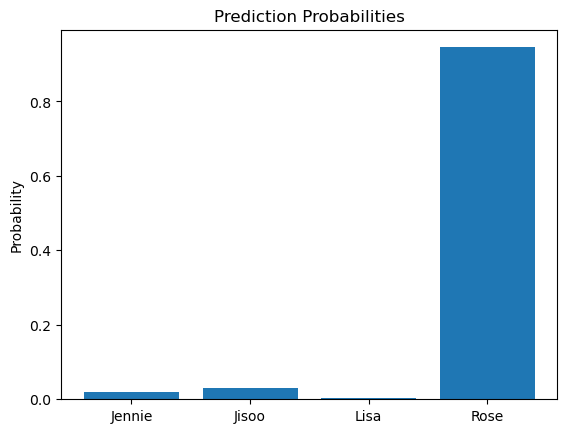

In [32]:
import os
import cv2
import numpy as np
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Example label map for your classification task
label_map = {
    'Jennie': 'Jennie',
    'Jisoo': 'Jisoo',
    'Lisa': 'Lisa',
    'Rose': 'Rose'
    # Add all the other class labels here
}


# Function to allow users to select an image file from their PC
def select_image_file():
    Tk().withdraw()  # Hide the root Tkinter window
    file_path = askopenfilename(
        title="Select an image file", 
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp *.tiff *.gif")]
    )
    return file_path

# Load and preprocess the selected image
def load_image_for_prediction(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Unable to read the image. Please check the file path.")
        return None
    
    image = cv2.resize(image, (128, 128))  # Resize to fixed dimensions used in training
    image = image.flatten()  # Flatten the image
    return np.array(image).reshape(1, -1)  # Reshape for model input

# Prediction function with probability output
def predict_image_class_with_probabilities(image_path, lda, svm_clf, scaler, label_map):
    image = load_image_for_prediction(image_path)
    if image is None:
        return
    
    # Preprocess the image using LDA and scaler
    image_lda = lda.transform(image)
    image_scaled = scaler.transform(image_lda)
    
    # Predict the class probabilities
    probabilities = svm_clf.predict_proba(image_scaled)[0]
    
    # Create a dictionary of class labels and their corresponding probabilities
    label_probabilities = {label: prob for label, prob in zip(label_map.keys(), probabilities)}
    
    return label_probabilities

# Training the model with the training dataset
def train_model(X_train, y_train):
    lda = LDA(n_components=3)
    X_train_lda = lda.fit_transform(X_train, y_train)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_lda)
    
    # Train the SVM classifier with probabilities enabled
    svm_clf = SVC(kernel='linear', C=0.5, probability=True)
    svm_clf.fit(X_train_scaled, y_train)
    
    return lda, svm_clf, scaler

# Train the model
lda, svm_clf, scaler = train_model(X_train, y_train)

# Let the user select the image from their PC
image_path = select_image_file()

if image_path:
    # Predict and display the probabilities for each class
    label_probabilities = predict_image_class_with_probabilities(image_path, lda, svm_clf, scaler, label_map)
    
    if label_probabilities:
        # Print the predicted probabilities
        print("Predicted probabilities:")
        for label, prob in label_probabilities.items():
            print(f"{label}: {prob * 100:.2f}%")
        
        # Optional: Plot the probabilities
        plt.bar(label_probabilities.keys(), label_probabilities.values())
        plt.title("Prediction Probabilities")
        plt.ylabel("Probability")
        plt.show()
    else:
        print("Error in predicting the class.")
else:
    print("No image selected.")